# Transformer Model

In [1]:
import re
import time
import pandas as pd
import numpy as np
import torch
from tqdm import trange
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast
import math
from pathlib import Path
from datasets import load_dataset
from tokenizers import Tokenizer, pre_tokenizers, models, trainers
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import torch.optim as optim
import pynvml

In [2]:
def relu(x):
    return torch.max(x, torch.tensor(0.0))

def softmax(x, dim: int = -1):
    max_val, _ = torch.max(x, dim=dim, keepdim=True)
    x_exp = torch.exp(x - max_val)
    sum_x_exp = torch.sum(x_exp, dim=dim, keepdim=True)
    return x_exp / sum_x_exp

In [3]:
class InputEmbeddings(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        if x is None:
            raise ValueError("Input to embedding is None")
        return self.embedding(x) * math.sqrt(self.d_model)

In [4]:
class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: int):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, dff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
         return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int, dropout: float):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -math.log(10000) / d_model)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1],:]).requires_grad_(False)
        return self.dropout(x)

In [6]:
class LayerNormalization(nn.Module):
    def __init__(self, eps: float = 10 ** -6):
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.alpha * ((x - mean) / torch.sqrt(std + self.eps)) + self.bias

In [7]:
class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: int):
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    
    def forward(self, x):
         return self.linear_2(self.dropout(relu(self.linear_1(x))))

In [8]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: int):
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, 'd_model is not divisible by h'
        self.d_k = d_model // h
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        attention_scores = ((query @ key.transpose(-2, -1)) / (math.sqrt(d_k)))
        
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
            
        attention_scores = softmax(attention_scores)
        
        if dropout is not None:
            attention_scores = dropout(attention_scores)
                        
        return attention_scores @ value, attention_scores
        
    def forward(self, q, k, v, mask):
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1,2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1,2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1,2)
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)
        return self.w_o(x)

In [9]:
class ResidualConnection(nn.Module):
    def __init__(self, dropout: float):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization()

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [10]:
class EncoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask))
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [11]:
class Encoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
            
        return self.norm(x)

In [12]:
class DecoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))
        x = self.residual_connections[2](x, self.feed_forward_block)                         
        return x

In [13]:
class Decoder(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

In [14]:
class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self,x):
        return torch.log(softmax(self.proj(x), dim=-1))

In [15]:
class Transformer(nn.Module):
    def __init__(self, 
                 encoder: Encoder, 
                 decoder: Decoder, 
                 src_embed: InputEmbeddings, 
                 tgt_embed: InputEmbeddings, 
                 src_pos: PositionalEncoding, 
                 tgt_pos: PositionalEncoding, 
                 projection_layer: ProjectionLayer):

        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        # Encode the source sequence
        encoder_output = self.encode(src, src_mask)
        
        # Decode the target sequence
        decoder_output = self.decode(encoder_output, src_mask, tgt, tgt_mask)
        
        # Project the decoder output to the vocabulary space
        output = self.projection_layer(decoder_output)
        
        return output

In [16]:
def build_transformer(src_vocab_size: int, 
                      tgt_vocab_size: int, 
                      src_seq_len: int, 
                      tgt_seq_len: int, 
                      d_model: int = 512, 
                      N: int = 6, 
                      h: int = 8, 
                      dropout: float = 0.1, 
                      d_ff: int = 2048
                     ) -> Transformer:

    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)
    encoder_blocks = []
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)

    decoder_blocks = []
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)

    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    for p in transformer.parameters():
        if p.dim() >1:
            nn.init.xavier_uniform_(p)

    return transformer

# Load in Data

In [17]:
load_dataset("Fishball02/anime-subtitle-dragon-ball")

DatasetDict({
    train: Dataset({
        features: ['episode', 'start', 'end', 'text'],
        num_rows: 27187
    })
})

In [18]:
load_dataset("Fishball02/anime-subtitle-dragon-ball")['train']['text']

["What's this...?",
 'Unfortunately, the Red Ribbon\\NArmy will be taking that treasure.',
 'If you wanna fight, then go ahead and try!',
 'My, how confident...',
 "You bastard! You'll regret that!",
 "I... can't move...!",
 'See you in the next world!',
 'G-Goku...!',
 '"The Eyes that Sparkle with Terror"',
 "I'll show you just how terrible\\NI can be! In full amount!",
 'You should be honored to die by my hands!',
 'You talk too much...!',
 "Every time I'm about to kill scum such as yourself...",
 '...each and every strand of my beautiful hair...',
 '...and my white, glowing skin tremble with pleasure!',
 'Come at me!',
 "What's with you?! You gross me out!",
 'Now you said it!',
 'Pandas on a picnic!',
 'G-Goku!',
 "Such nice friends!\\NHere's another freebie!",
 'The Dragon Ball absolutely...',
 'Die!',
 'H-How dare you discolor my pink cheeks...?!',
 "Now it's my turn! Here I come!",
 "You're nothing special!",
 'A-Amazing!',
 "Goku's grown even stronger than he was at the Tenkaic

In [19]:
def remove_stutter(text):
    stutter_pattern = re.compile(r'\b(\w)-\1(\w+)\b', re.IGNORECASE)
    corrected_text = stutter_pattern.sub(r'\1\2', text)
    return corrected_text

def get_and_preprocess_dbz_data():
    text = [example for example in load_dataset("Fishball02/anime-subtitle-dragon-ball")['train']['text']]
    text = [' '.join(t.replace('\\N', ' ').replace('.', ' ').replace('\'', '').split()) for t in text]
    text = [remove_stutter(t) for t in text]
    text = [' '.join(t.replace('-', ' ').split()) for t in text]
    return text

In [20]:
nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

def plot_distribution(text):
    text = [remove_stopwords(t) for t in text]
    lengths = [len(example.split()) for example in text]
    plt.hist(lengths, bins=50)
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.show()

def plot_wordcloud(text):
    text = [remove_stopwords(t) for t in text]
    text = ' '.join([t for t in text])
    tokens = nltk.word_tokenize(text)
    processed_text = ' '.join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(processed_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amram\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amram\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


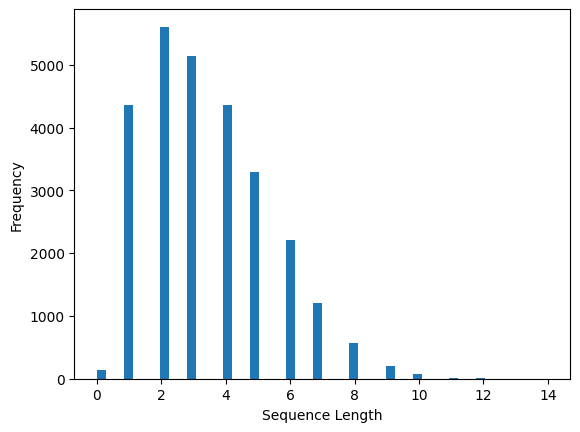

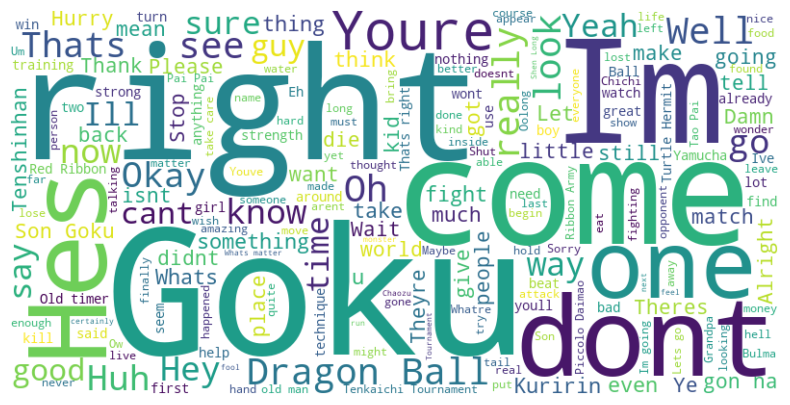

In [21]:
text = get_and_preprocess_dbz_data()
plot_distribution(text)
plot_wordcloud(text)

In [22]:
class DragonBallZChatbotDataset(Dataset):
    def __init__(self, ds, tokenizer, seq_len):
        super().__init__()
        self.ds = ds
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.sos_token = tokenizer.token_to_id('[SOS]')
        self.eos_token = tokenizer.token_to_id('[EOS]')
        self.pad_token = tokenizer.token_to_id('[PAD]')

    def __len__(self):
        return len(self.ds) - 1  # Since we are using pairs

    def __getitem__(self, index):
        context = self.ds[index]['text']
        response = self.ds[index + 1]['text']
        context_tokens = self.tokenizer.encode(context).ids
        response_tokens = self.tokenizer.encode(response).ids
        
        # Add special tokens
        context_tokens = [self.sos_token] + context_tokens + [self.eos_token]
        response_tokens = [self.sos_token] + response_tokens + [self.eos_token]
        
        # Padding
        context_tokens = context_tokens[:self.seq_len] + [self.pad_token] * (self.seq_len - len(context_tokens))
        response_tokens = response_tokens[:self.seq_len] + [self.pad_token] * (self.seq_len - len(response_tokens))
        
        return torch.tensor(context_tokens[:self.seq_len], dtype=torch.long), torch.tensor(response_tokens[:self.seq_len], dtype=torch.long)

In [23]:
def get_or_build_tokenizer(config: dict, ds = None):
    tokenizer_path = Path(config['tokenizer_file'])
    if not tokenizer_path.exists():
        tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))
        tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
        trainer = trainers.WordLevelTrainer(
            special_tokens=['[UNK]', '[PAD]', '[SOS]', '[EOS]'],
            min_frequency=2
        )

        tokenizer.train_from_iterator(ds, trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))

    return tokenizer

In [24]:
def get_ds(config: dict):
    # Load the Dragon Ball Z dataset
    # ds_raw = get_and_preprocess_dbz_data()
    ds_raw = load_dataset("Fishball02/anime-subtitle-dragon-ball")['train']
    
    print(ds_raw)
    
    # Build or load the tokenizer
    tokenizer = get_or_build_tokenizer(config, ds_raw)

    # Split the dataset into training and validation sets
    train_ds_size = int(0.9 * len(ds_raw))
    val_ds_size = len(ds_raw) - train_ds_size
    train_ds_raw, val_ds_raw = random_split(ds_raw, (train_ds_size, val_ds_size))

    # Create the dataset
    train_ds = DragonBallZChatbotDataset(train_ds_raw, tokenizer, config['seq_len'])
    val_ds = DragonBallZChatbotDataset(val_ds_raw, tokenizer, config['seq_len'])

    return train_ds, val_ds

In [25]:
def custom_collate_fn(batch):
    filtered_batch = []
    for item in batch:
        try:
            context, response = item
            if context is not None and response is not None:
                filtered_batch.append((context, response))
        except ValueError:
            # Skip the problematic sample
            continue
    return torch.utils.data.dataloader.default_collate(filtered_batch)

In [26]:
def print_gpu_utilization():
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used // 1024 ** 2:.2f} MB.")

In [27]:
def train_chatbot(config: dict):
    model_path = Path('./dbzLLM.pt')
    if not model_path.exists():
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f'The neural network will be running on {device}')
        data_load_time = time.time()
        train_ds, val_ds = get_ds(config=config)
        train_loader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True, collate_fn=custom_collate_fn, pin_memory=True)
        val_loader = DataLoader(val_ds, batch_size=config['batch_size'], shuffle=False, collate_fn=custom_collate_fn, pin_memory=True)
        vocab_size = len(get_or_build_tokenizer(config).get_vocab())
        model_build_time = time.time()
        model = build_transformer(vocab_size, vocab_size, config['seq_len'], config['seq_len'], 
                                  d_model=config['d_model'], N=config['N'], 
                                  h=config['h'], dropout=config['dropout'], d_ff=config['d_ff'])
        model.to(device)
        criterion = nn.CrossEntropyLoss(ignore_index=train_ds.pad_token)
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)
        scaler = GradScaler()
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0
        for epoch in trange(config['num_epochs']):
            model.train()
            train_loss = 0
            for context, response in train_loader:
                context = context.to(device, non_blocking=True)
                response = context.to(device, non_blocking=True)
                
                optimizer.zero_grad()
                
                # Check embedding outputs
                context_embed = model.src_embed(context)
                response_embed = model.tgt_embed(response)
                
                
                with autocast():
                    output = model(context, response)
                    loss = criterion(output.view(-1, vocab_size), response.view(-1))
                    
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                
                train_loss += loss.item()
    
            train_loss /= len(train_loader)
            print_gpu_utilization()
            print(f'Epoch {epoch + 1}/{config["num_epochs"]}, Loss: {loss.item()}')
        
            # Validation loop (optional)
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for context, response in val_loader:
                    context = context.to(device, non_blocking=True)
                    response = response.to(device, non_blocking=True)
                    with autocast():
                        output = model(context, response)
                        loss = criterion(output.view(-1, vocab_size), response.view(-1))
                
                val_loss += loss.item()

            val_loss /= len(val_loader)
            print(f'Epoch {epoch + 1}/{config["num_epochs"]}, Validation Loss: {val_loss}')
        
            scheduler.step(val_loss)
    
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                
                torch.save(
                    {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()
                    }, 
                    './dbzMHA.pt'
                )
                
                patience_counter = 0
            else:
                patience_counter += 1
    
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

            
        torch.save(model.state_dict(), './dbzLLM.pt')
    else:
        pass

In [28]:
def load_chatbot(device, vocab_size: int):
    model = build_transformer(src_vocab_size=vocab_size, 
                              tgt_vocab_size=vocab_size, 
                              src_seq_len=config['seq_len'], 
                              tgt_seq_len=config['seq_len'], 
                              d_model=config['d_model'], 
                              N=config['N'], 
                              h=config['h'], 
                              dropout=config['dropout'], 
                              d_ff=config['d_ff']
                             )
    
    model.load_state_dict(torch.load('./dbzLLM.pt'))
    model.to(device)
    model.eval()
    return model

def preprocess_sentence(sentence, tokenizer, seq_len, device):
    tokens = tokenizer.encode(sentence).ids
    tokens = [tokenizer.token_to_id('[SOS]')] + tokens + [tokenizer.token_to_id('[EOS]')]
    tokens = tokens[:seq_len] + [tokenizer.token_to_id('[PAD]')] * (seq_len - len(tokens))
    return torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

def chatbot_predict(model, sentence, tokenizer, seq_len, device):
    model.eval()
    input_tokens = preprocess_sentence(sentence, tokenizer, seq_len, device)
    
    
    with torch.no_grad():
        output_tokens = model(input_tokens, input_tokens)
        
    output_ids = output_tokens.argmax(dim=-1).squeeze().tolist()
    output_sentence = tokenizer.decode(output_ids, skip_special_tokens=True)
    return output_sentence

def chat(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokenizer = get_or_build_tokenizer(config)
    vocab_size = len(tokenizer.get_vocab())
    chatbot = load_chatbot(device=device, vocab_size=vocab_size)
    name = 'Tim'
    while True:
        command = print('Type `quit` to end chatting')    
        sentence = input('You: ')
        if 'quit' == sentence:
            break
            
        output = chatbot_predict(chatbot, sentence, tokenizer, config['seq_len'], device)
        print(f'{name}: {output}')

In [29]:
# Configuration dictionary
config = {
    'tokenizer_file': './tokenizer.json',
    'dropout': 0.1,
    'seq_len': 128,
    'batch_size': 32,
    'd_model': 512,
    'h': 8,
    'N': 6,
    'num_decoder_layers': 6,
    'd_ff': 2048,
    'num_epochs': 100,
    'learning_rate': 1e-4
}

In [ ]:
train_chatbot(config=config)

The neural network will be running on cuda
Dataset({
    features: ['episode', 'start', 'end', 'text'],
    num_rows: 27187
})


C:\Python\Python3_11_7\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

In [ ]:
chat(config)